# Image classification

In [1]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#import libraries
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds

In [3]:
#setting hyperparameters
batch_size = 128
num_classes = 10
epochs = 20
image_size = (32,32)

In [ ]:
#load cifar10 train, test and validation datasets
(train_ds, test_ds, validation_ds), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test[:50%]', 'test[50%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [5]:
#image preprocessing
def preprocess_image(image, label):
    resized_image = tf.image.resize(image, [32, 32])
    return resized_image, label

In [6]:
#image augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

In [7]:
#train dataset
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .cache()
    .shuffle(ds_info.splits['train'].num_examples)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

#validation dataset
validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

#test dataset
test_ds = (
    test_ds
    .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

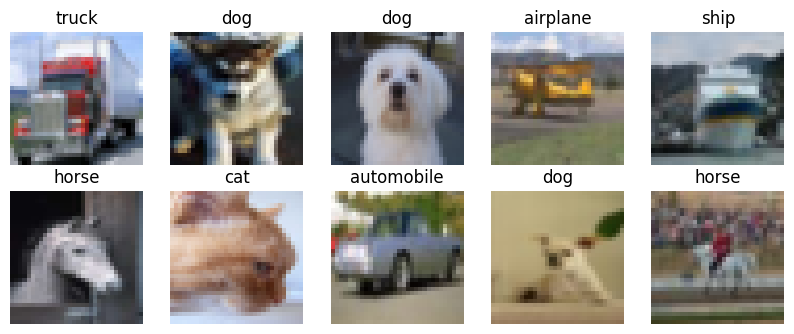

In [8]:
#dispaly datasets with labes for 10 train datasets using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(ds_info.features['label'].names[labels[i]])
        plt.axis('off')

In [9]:
def model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = model(input_shape=image_size + (3,), num_classes=10)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 128)          3584      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 128)          512       ['conv2d[0][0]']              
 Normalization)                                                                               

In [10]:
#compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
#train model
epochs = 100
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
)

In [12]:
#evaluate model
loss, acc = model.evaluate(test_ds)
print('Accuracy', acc)


40/40 [==============================] - 1s 17ms/step - loss: 1.4574 - accuracy: 0.7936
Accuracy 0.7936000227928162


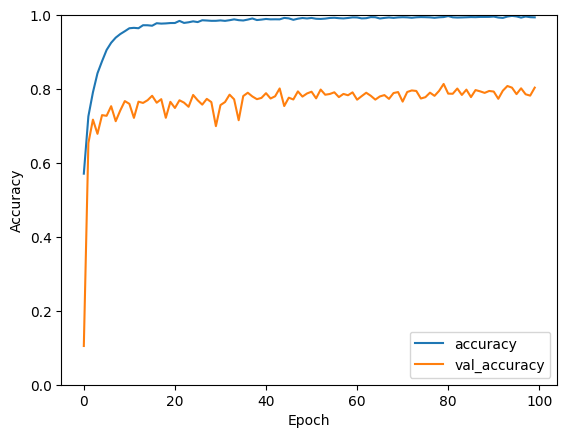

In [13]:
#plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
#save model
model.save('model.h5')
